In [2]:
import os
from torchvision import datasets, transforms
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, random_split
import random


In [3]:
train_dir = 'data/seg_train/seg_train'
test_dir = 'data/seg_test/seg_test'

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),         
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [5]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=transform)

In [6]:
print("Train dataset classes:", train_dataset.classes)
print("Number of training images:", len(train_dataset))
print("Test dataset classes:", test_dataset.classes)
print("Number of test images:", len(test_dataset))

Train dataset classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Number of training images: 14034
Test dataset classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Number of test images: 3000


In [7]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

print(f"Train subset: {len(train_subset)} images")
print(f"Validation subset: {len(val_subset)} images")

Train subset: 11227 images
Validation subset: 2807 images


In [8]:
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [9]:
def denormalize(img_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)
    return img_tensor


In [10]:
images, labels = next(iter(train_loader))
print("A single batch shape:", images.shape) 

A single batch shape: torch.Size([32, 3, 224, 224])


In [11]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),    # 50% chance to flip horizontally
    transforms.RandomRotation(degrees=15),     # rotate images randomly by ±15°
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [12]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [13]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=test_transform)

In [14]:
class_names = train_dataset.classes  # e.g. ['buildings', 'forest', 'glacier', ...]
class_counts = {cls_name: 0 for cls_name in class_names}

In [15]:
for _, label_idx in train_dataset.samples:
    class_name = class_names[label_idx]
    class_counts[class_name] += 1

In [16]:
print("Class distribution (training set):")
for cls, count in class_counts.items():
    print(f"  {cls}: {count} images")


Class distribution (training set):
  buildings: 2191 images
  forest: 2271 images
  glacier: 2404 images
  mountain: 2512 images
  sea: 2274 images
  street: 2382 images


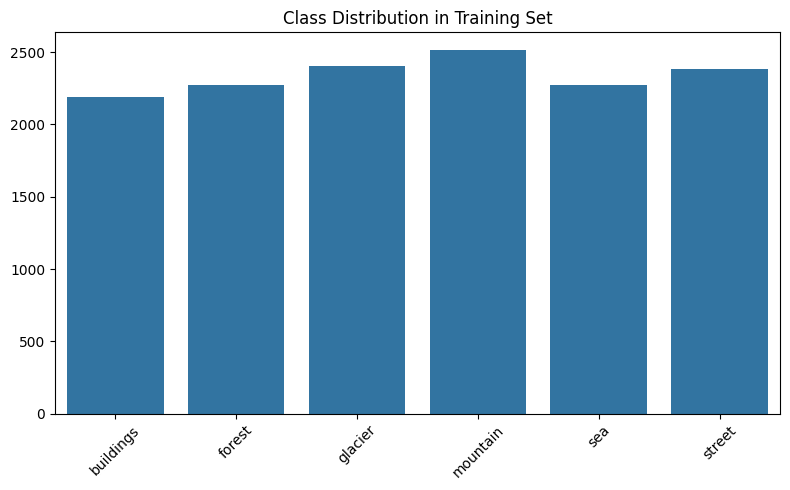

In [17]:
plt.figure(figsize=(8, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Class Distribution in Training Set")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
def show_random_images_per_class(dataset, classes, num_images=2):
    """
    Shows 'num_images' random images from each class in the dataset.
    """
    # Group image indices by class
    class_to_indices = {cls: [] for cls in classes}
    for idx, (_, label_idx) in enumerate(dataset.samples):
        class_to_indices[classes[label_idx]].append(idx)
    
    # For each class, pick random indices and visualize
    fig, axes = plt.subplots(len(classes), num_images, figsize=(num_images*3, len(classes)*3))
    if len(classes) == 1:
        axes = [axes]  # handle case with single class
    for i, cls in enumerate(classes):
        indices = class_to_indices[cls]
        random_indices = random.sample(indices, k=min(num_images, len(indices)))
        for j in range(num_images):
            ax = axes[i][j] if len(classes) > 1 else axes[j]
            sample_idx = random_indices[j]
            img_path, label_idx = dataset.samples[sample_idx]
            
            # Load the image directly (without transforms) for a raw look
            # If you want to see after transforms, you'd get it from dataset[sample_idx]
            from PIL import Image
            img = Image.open(img_path)
            
            ax.imshow(img)
            ax.set_title(f"Class: {cls}")
            ax.axis('off')
    plt.tight_layout()
    plt.show()

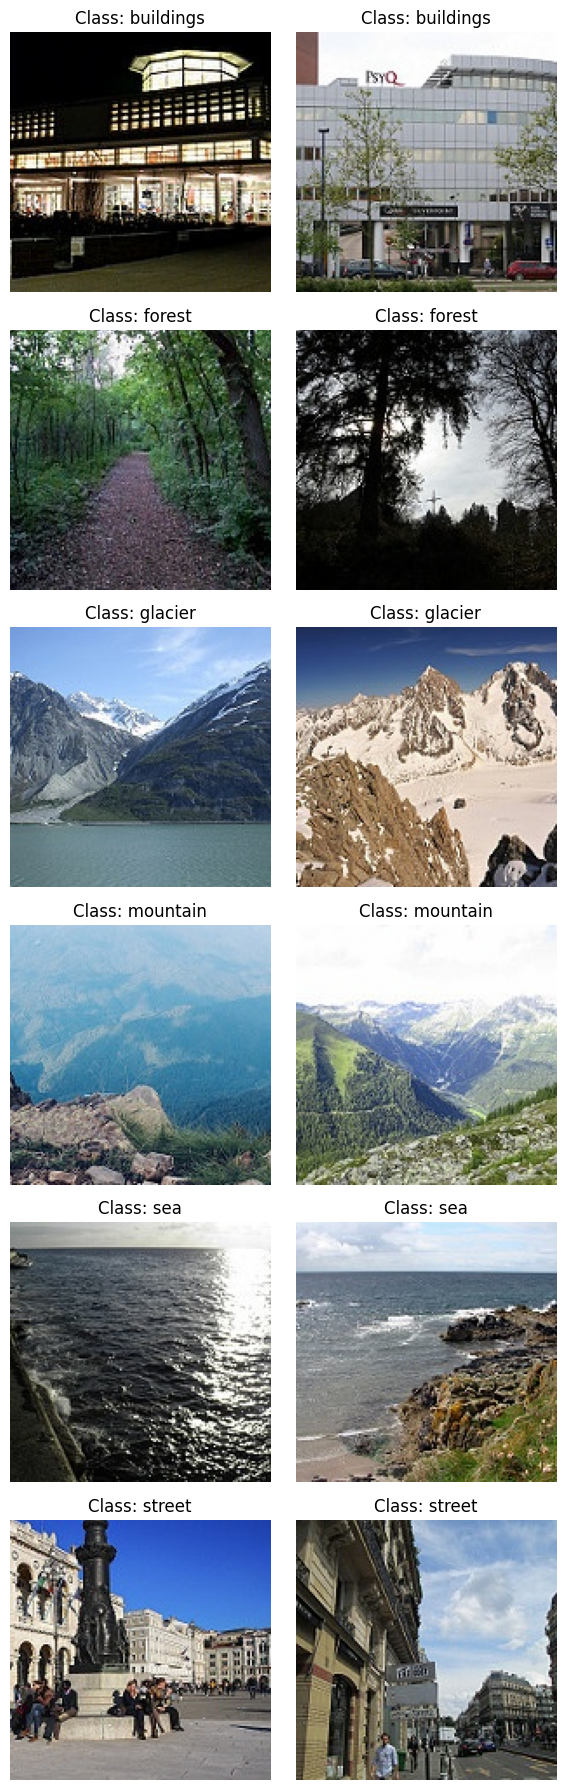

In [19]:
show_random_images_per_class(train_dataset, train_dataset.classes, num_images=2)

**PART 2**

In [20]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(SimpleCNN, self).__init__()
        # Convolutional Block 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Convolutional Block 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Convolutional Block 3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # After three pooling operations: 224 -> 112 -> 56 -> 28 (spatial dimensions become 28x28)
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
        # For classification, we will use CrossEntropyLoss, which expects raw logits

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu_fc1(self.fc1(x))
        x = self.fc2(x)
        return x

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=6).to(device)
print(model)


SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (relu_fc1): ReLU()
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


In [22]:
import torch.optim as optim

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
num_epochs = 20
train_losses = []
val_accuracies = []

In [25]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Validate
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    val_acc = correct / total
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Loss={epoch_loss:.4f}, Val Accuracy={val_acc:.4f}")

Epoch 1/20: Loss=0.9444, Val Accuracy=0.7378
Epoch 2/20: Loss=0.5745, Val Accuracy=0.7912
Epoch 3/20: Loss=0.3833, Val Accuracy=0.7884
Epoch 4/20: Loss=0.2258, Val Accuracy=0.7770
Epoch 5/20: Loss=0.1232, Val Accuracy=0.7948
Epoch 6/20: Loss=0.0809, Val Accuracy=0.7909
Epoch 7/20: Loss=0.0439, Val Accuracy=0.7834
Epoch 8/20: Loss=0.0483, Val Accuracy=0.7937
Epoch 9/20: Loss=0.0415, Val Accuracy=0.7845
Epoch 10/20: Loss=0.0292, Val Accuracy=0.7773
Epoch 11/20: Loss=0.0400, Val Accuracy=0.7663
Epoch 12/20: Loss=0.0222, Val Accuracy=0.7891
Epoch 13/20: Loss=0.0155, Val Accuracy=0.7941
Epoch 14/20: Loss=0.0314, Val Accuracy=0.7820
Epoch 15/20: Loss=0.0393, Val Accuracy=0.7731
Epoch 16/20: Loss=0.0279, Val Accuracy=0.7962
Epoch 17/20: Loss=0.0121, Val Accuracy=0.7909
Epoch 18/20: Loss=0.0062, Val Accuracy=0.7976
Epoch 19/20: Loss=0.0035, Val Accuracy=0.7905
Epoch 20/20: Loss=0.0020, Val Accuracy=0.7976


In [26]:
torch.save(model.state_dict(), "simple_cnn_intel.pth")


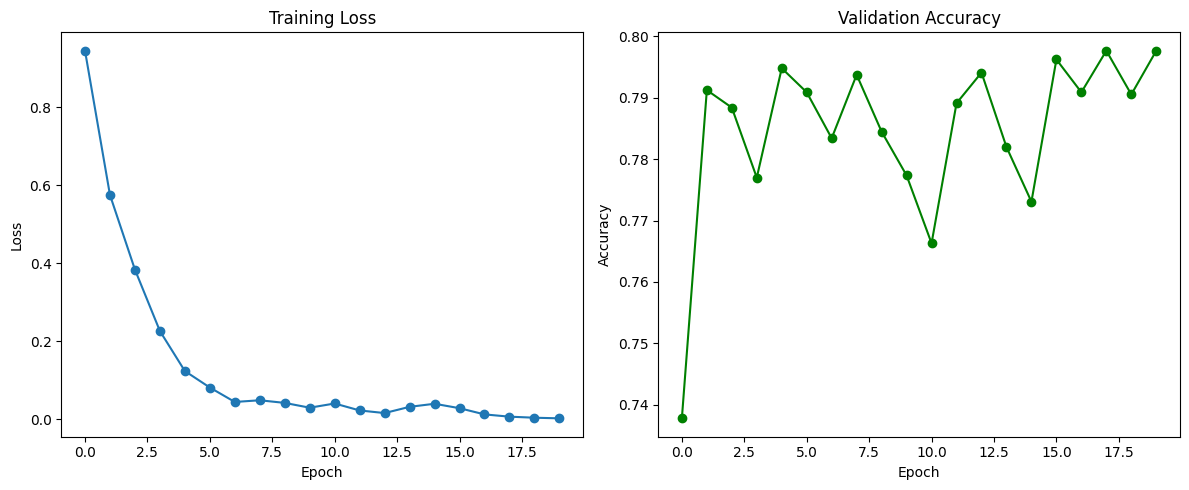

In [27]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, marker='o', color='green')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()

In [28]:
model.eval()

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (relu_fc1): ReLU()
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

In [29]:
data_iter = iter(test_loader)
images, labels = next(data_iter)
images = images.to(device)
labels = labels.to(device)


In [30]:
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)


In [39]:
num_images = 16

In [42]:
indices = random.sample(range(len(test_dataset)), num_images)
samples = [test_dataset[i] for i in indices]
images, labels = zip(*samples)

In [44]:
images_batch = torch.stack([img for img in images], dim=0).to(device)
labels_batch = torch.tensor(labels, dtype=torch.long, device=device)

In [45]:
with torch.no_grad():
    outputs = model(images_batch)
    _, preds = torch.max(outputs, 1)


In [32]:
def denormalize_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Denormalizes an image tensor and converts it to a NumPy array with shape (H, W, C).
    """
    img = img.clone().cpu()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    np_img = img.numpy().transpose((1, 2, 0))
    np_img = np.clip(np_img, 0, 1)
    return np_img

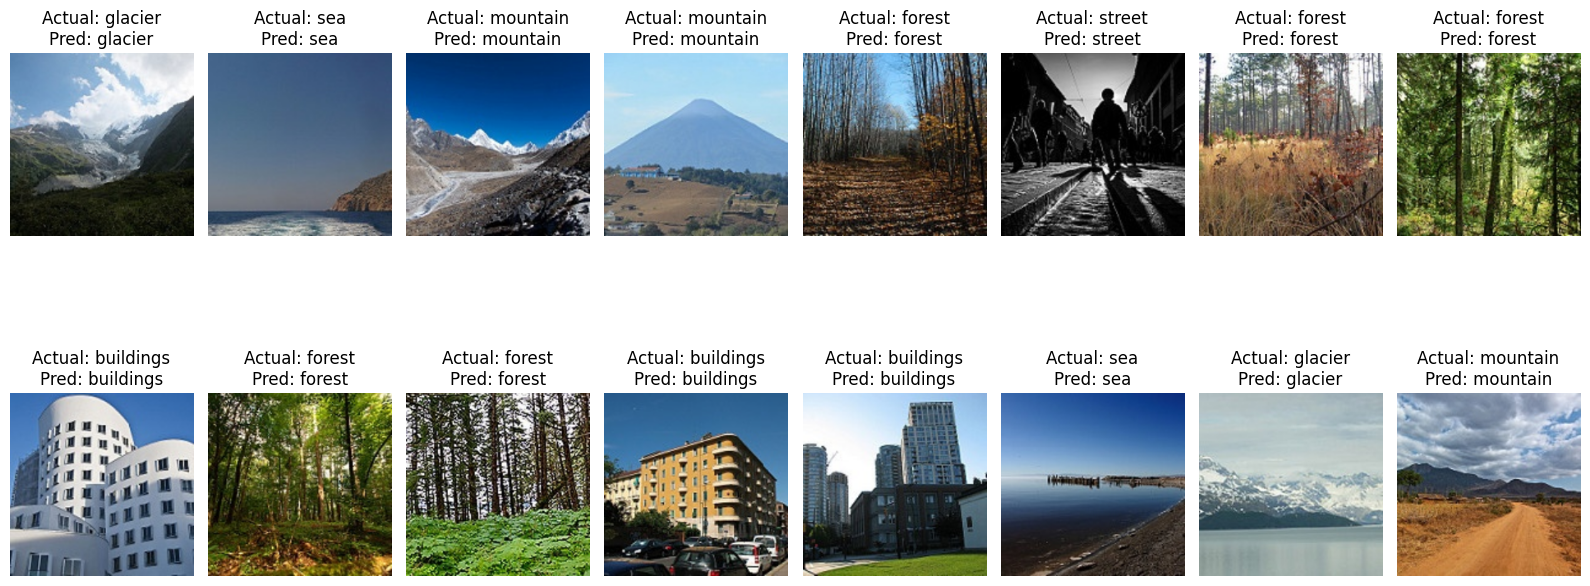

In [47]:
plt.figure(figsize=(16, 8))
for i in range(num_images):
    ax = plt.subplot(2, 8, i+1)
    # Denormalize for display
    np_img = denormalize_image(images_batch[i])
    plt.imshow(np_img)
    actual_label = test_dataset.classes[labels_batch[i]]
    predicted_label = test_dataset.classes[preds[i]]
    plt.title(f"Actual: {actual_label}\nPred: {predicted_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Even simplest CNN on 20 epochs can show good results, looking forward to the next practice